In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tf_util.stat_util import approx_equal
from dsn.util.systems import SCCircuit

EPS = 1e-12
DTYPE = tf.float64

np.random.seed(0)
M = 100
sess = tf.Session()
#true_sys = v1_circuit(T=T, dt=dt)
Z = tf.placeholder(dtype=DTYPE, shape=(1, M, None))

# difference behavior 1
p = 0.8
pvar = 0.01
means = np.array([p, p*(1-p)])
variances = np.array([pvar, pvar])
behavior1 = {
    "type": "standard",
    "means": means,
    "variances": variances,
}

# ****************************************
# One random fixed param
# ****************************************

fixed_params = {"E_constant": 0.0}
system = SCCircuit(fixed_params, behavior1)
assert system.name == "SCCircuit"
assert approx_equal(system.behavior["means"], means, EPS)
assert approx_equal(system.behavior["variances"], variances, EPS)
assert system.fixed_params["E_constant"] == 0.0
assert len(system.fixed_params.keys()) == 1
assert system.all_params == [
    "sW",
    "vW",
    "dW",
    "hW",
    "E_constant",
    "E_Pbias",
    "E_Prule",
    "E_Arule",
    "E_choice",
    "E_light",
]
assert system.free_params == [
    "sW",
    "vW",
    "dW",
    "hW",
    "E_Pbias",
    "E_Prule",
    "E_Arule",
    "E_choice",
    "E_light",
]
assert system.z_labels == [
    r"$sW$",
    r"$vW$",
    r"$dW$",
    r"$hW$",
    r"$E_{P,bias}$",
    r"$E_{P,rule}$",
    r"$E_{A,rule}$",
    r"$E_{choice}$",
    r"$E_{light}$",
]
assert system.T_x_labels == [
    r"$E_{\partial W}left[ {V_{LP},L} \right]$",
    r"$Var_{\partial W}left[ {V_{LP},L} \right]$",
    r"$E_{\partial W}left[ {V_{LP},L} \right]^2$",
    r"$Var_{\partial W}left[ {V_{LP},L} \right]^2$",
]
assert system.D == 9
assert system.num_suff_stats == 4



/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


In [2]:
p = 0.8
pvar = 0.01
means = np.array([p, p*(1-p)])
variances = np.array([pvar, pvar])
behavior = {
    "type": "standard",
    "means": means,
    "variances": variances,
}

# ****************************************
# One random fixed param
# ****************************************
E_constant = 0.0
E_Pbias = 0.1
E_Prule = 0.5
E_Arule = 0.5
E_choice = -0.2
E_light = 0.1

fixed_params = {"E_constant":E_constant, \
                "E_Pbias":E_Pbias, \
                "E_Prule":E_Prule, \
                "E_Arule":E_Arule, \
                "E_choice":E_choice, \
                "E_light":E_light, \
               }

system = SCCircuit(fixed_params, behavior)

_Z = np.random.normal(0.0, 1.0, (1, M, 4))

# Test simulation
r_t = system.simulate(Z)
print(r_t.shape)

(75, 1, 100, 4, 100)


In [3]:
_r_t = sess.run(r_t, {Z:_Z})

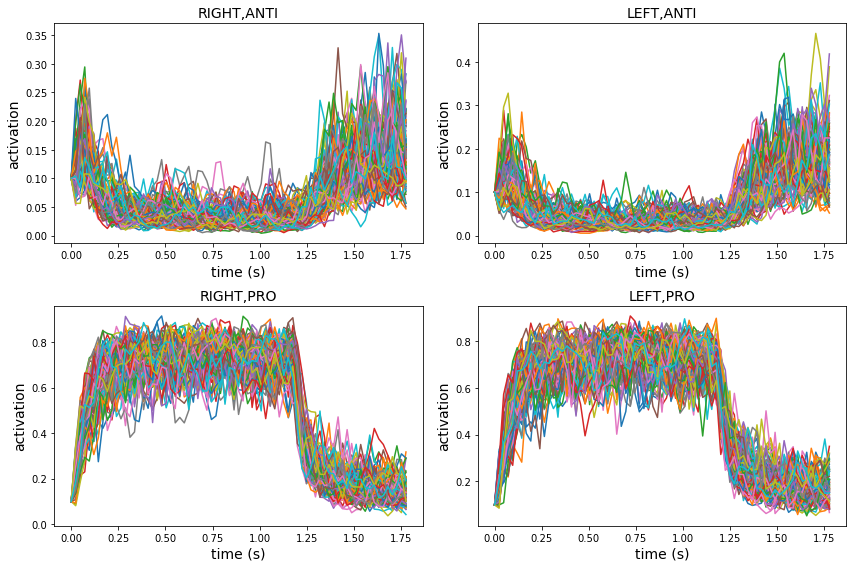

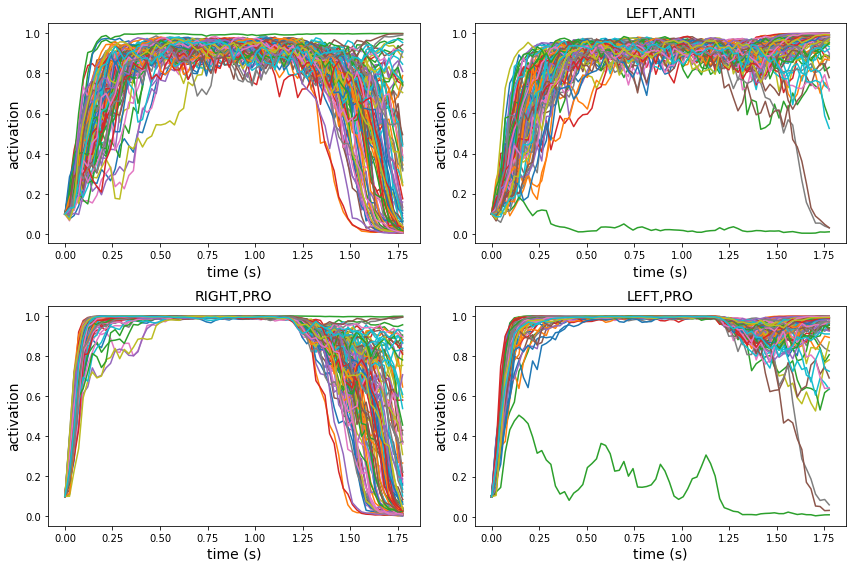

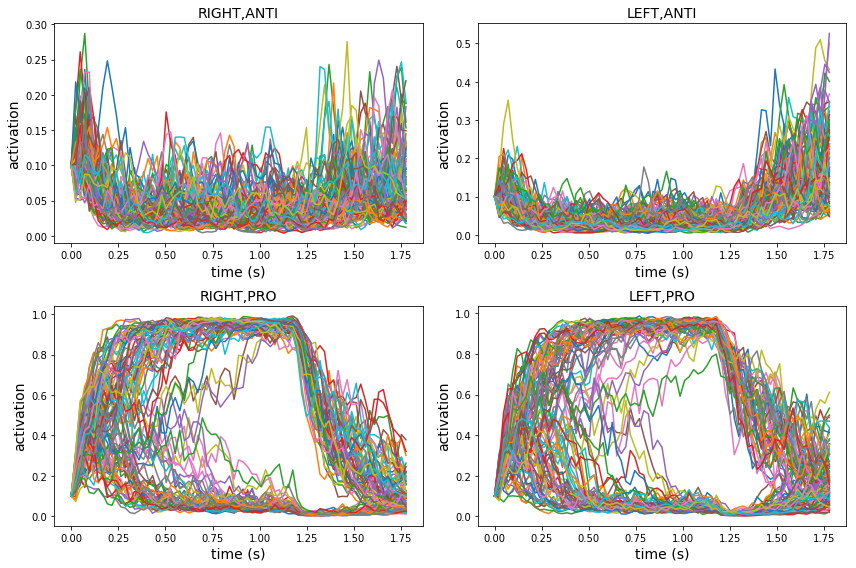

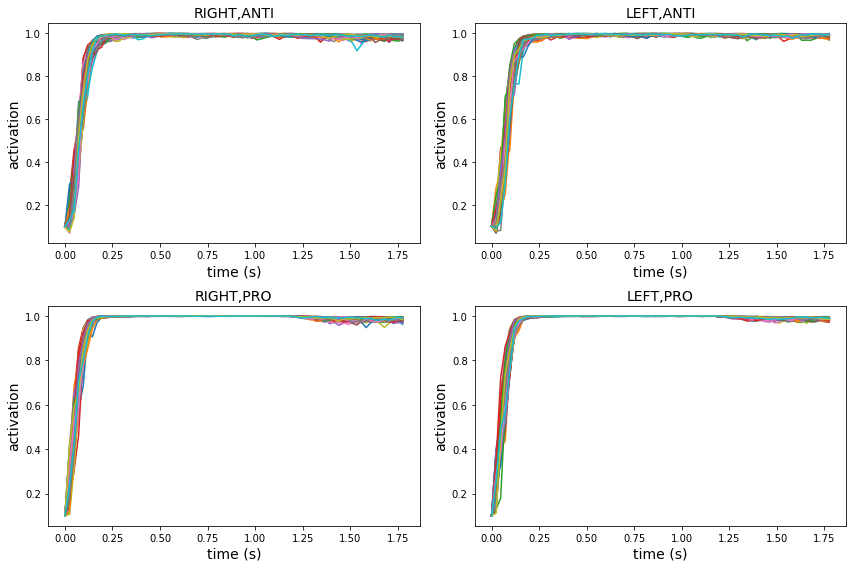

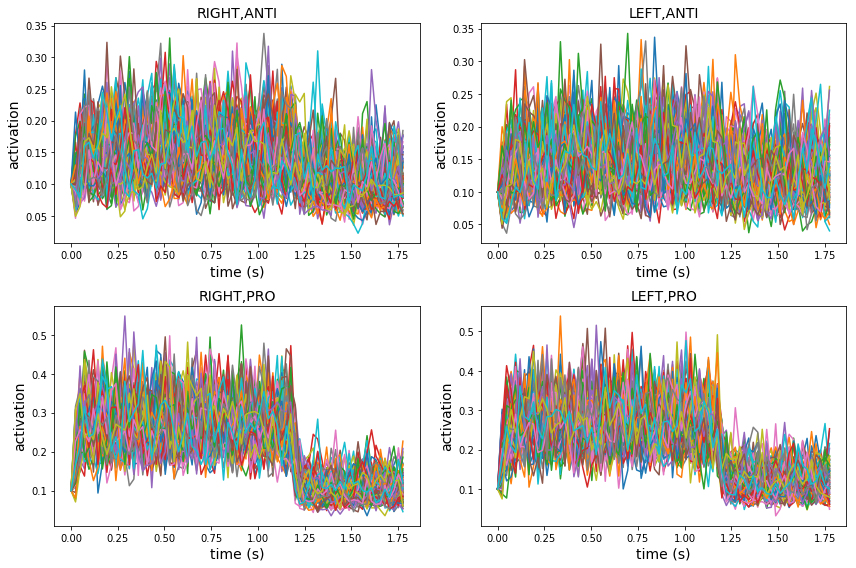

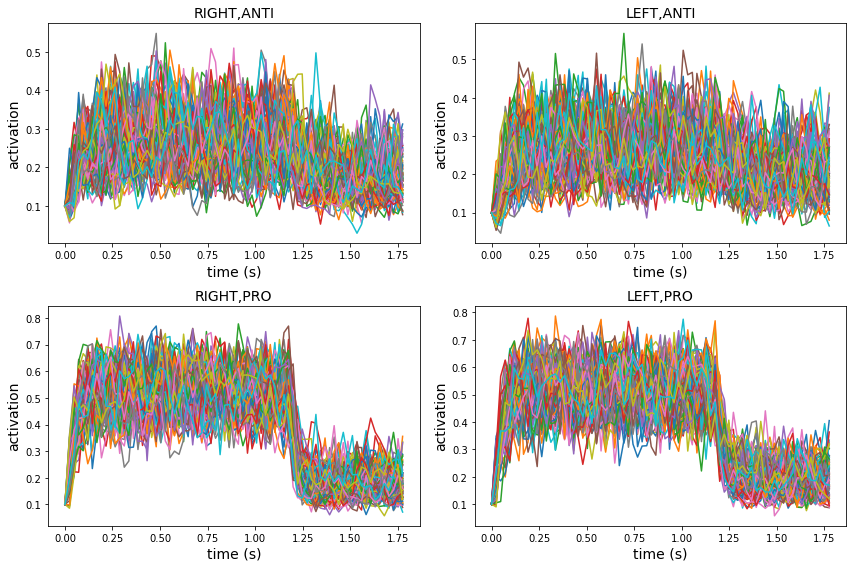

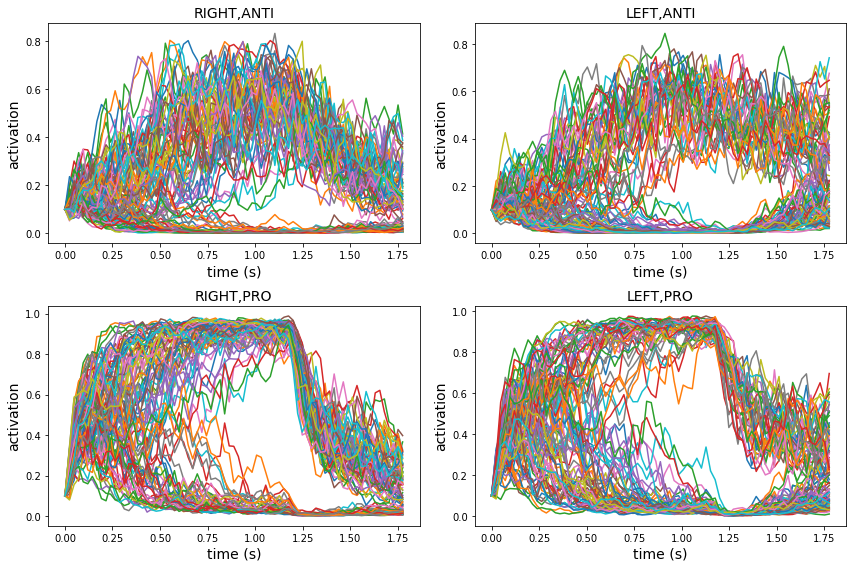

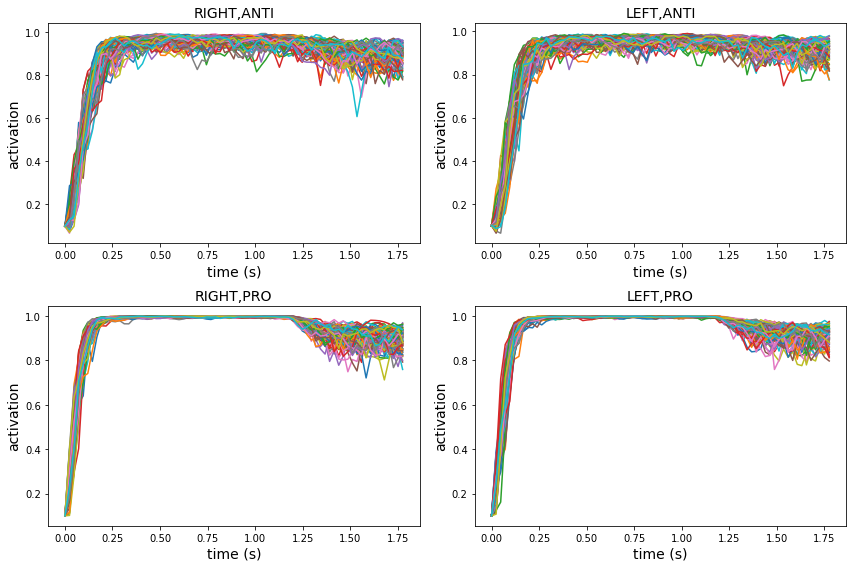

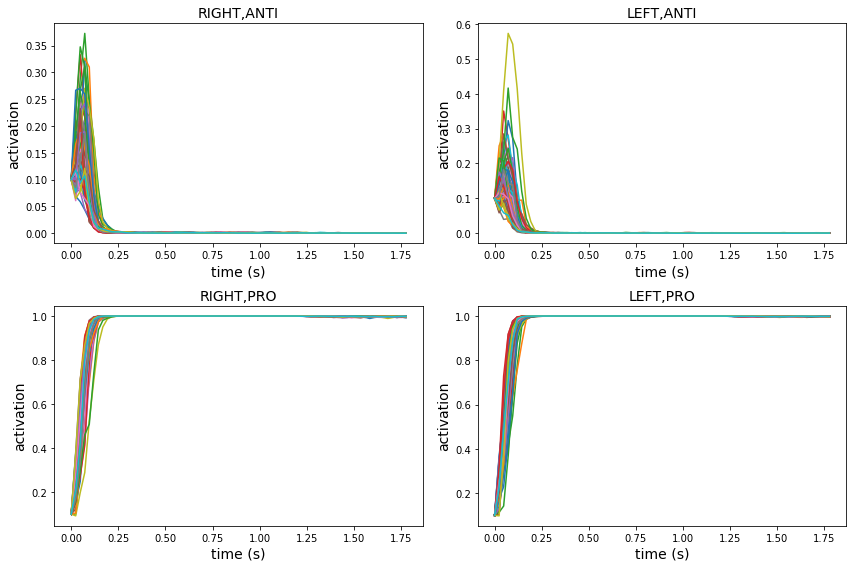

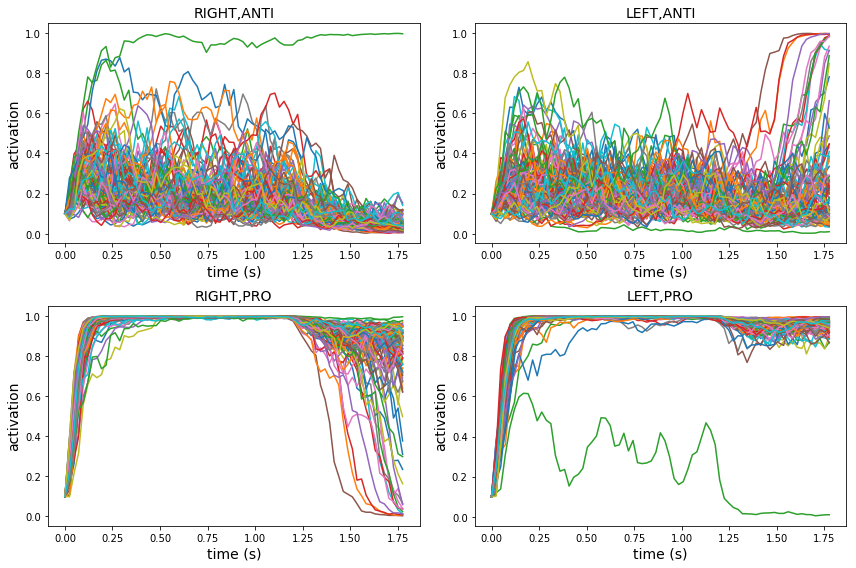

In [4]:
fontsize = 14
titles = ['LEFT,PRO', 'LEFT,ANTI', 'RIGHT,ANTI', 'RIGHT,PRO']
row_inds = [1, 0, 0, 1]
col_inds = [1, 1, 0, 0]
for k in range(10):
    fig, axs = plt.subplots(2,2,figsize=(12,8))
    for ind in range(4):
        ax = axs[row_inds[ind]][col_inds[ind]]
        ax.plot(system.t, _r_t[:,0,k,ind,:])
        ax.set_xlabel('time (s)', fontsize=fontsize)
        ax.set_ylabel('activation', fontsize=fontsize)
        ax.set_title(titles[ind], fontsize=fontsize)
    plt.tight_layout()
    plt.show()
    

In [5]:
class sc_circuit():
    def __init__(self,):
        # time course for task
        self.t_cue_delay = 1.2
        self.t_choice = 0.6
        t_total = self.t_cue_delay + self.t_choice
        self.dt = 0.024
        self.t = np.arange(0.0, t_total, self.dt)
        self.T = self.t.shape[0]


    def simulate(self, W, Evals, w):
        # declare params
        dt = 0.024
        theta = 0.05
        beta = 0.5
        tau = 0.09
        sigma = 0.3
        
        # make inputs
        E_constant, E_Pbias, E_Prule, E_Arule, E_choice, E_light = Evals

        I_constant = np.tile(E_constant*np.array([[1, 1, 1, 1]]), (self.T, 1))

        I_Pbias = np.zeros((self.T,4))
        I_Pbias[self.t < 1.2] = E_Pbias*np.array([1, 0, 0, 1])

        I_Prule = np.zeros((self.T,4))
        I_Prule[self.t < 1.2] = E_Prule*np.array([1, 0, 0, 1])

        I_Arule = np.zeros((self.T,4))
        I_Arule[self.t < 1.2] = E_Arule*np.array([0, 1, 1, 0])

        I_choice = np.zeros((self.T,4))
        I_choice[self.t > 1.2] = E_choice*np.array([1, 1, 1, 1])

        I_lightL = np.zeros((self.T,4))
        I_lightL[self.t > 1.2] = E_light*np.array([1, 1, 0, 0])

        I_lightR = np.zeros((self.T,4))
        I_lightR[self.t > 1.2] = E_light*np.array([0, 0, 1, 1])

        I_LP = I_constant + I_Pbias + I_Prule + I_choice + I_lightL

        u = np.zeros((self.T, 4))
        v = np.zeros((self.T, 4))

        # initialization
        v0 = np.array([0.1, 0.1, 0.1, 0.1])
        u0 = beta*np.arctanh(2*v0 - 1) - theta

        v[0] = v0
        u[0] = u0
        for i in range(1,self.T):
            du = (dt/tau) * (-u[i-1] + np.dot(W, v[i-1]) + I_LP[i] + sigma*w[i])
            u[i] = u[i-1]+du
            v[i] = 0.5*np.tanh((u[i] - theta)/beta) + 0.5

        return v
    
true_sys = sc_circuit()

_sW = _Z[0,:,0]
_vW = _Z[0,:,1]
_dW = _Z[0,:,2]
_hW = _Z[0,:,3]
W = np.array([[_sW, _vW, _dW, _hW], 
              [_vW, _sW, _hW, _dW], 
              [_dW, _hW, _sW, _vW], 
              [_hW, _dW, _vW, _sW]])
W = np.transpose(W, [2, 0, 1])

Es = [E_constant, E_Pbias, E_Prule, E_Arule, E_choice, E_light]
_w = system.w
N = _w.shape[4]

r_t_true = np.zeros((system.T, 1, M, 4, system.N))
for i in range(M):
    for j in range(N):
        _r_t_true_ij = true_sys.simulate(W[i], Es, _w[:,0,0,:,j])
        r_t_true[:,0,i,:,j] = _r_t_true_ij
assert(approx_equal(_r_t, r_t_true, EPS))

In [6]:
print(_r_t.shape, r_t_true.shape)
assert(approx_equal(_r_t, r_t_true, EPS))

(75, 1, 100, 4, 100) (75, 1, 100, 4, 100)
